# Dependencies and dataset

In [1]:
# Import fastai vision library methods to the local namespace
from fastai.vision.all import *

# Use fastai untar_data to get external dataset. 
# This method stores the download into user\.fastai\data by default
# The images of this particular dataset are in \oxford-iiit-pet\images
# Returns the path. We add the images folder in the extracted dataset path after with /' images'
path = untar_data(URLs.PETS)/'images'

# Device setup
I noticed that training was drawing on my cpu.
That finetune run took 14m 13s on my cpu.
The default package fastai does not install torch and torchvision with cuda support. 
So I uninstalled them from my venv and reinstalled them with cuda support using these commands:

pip uninstall torch torchvision
pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html

-> Successfully installed torch-2.0.1+cu118 torchvision-0.15.2+cu118

(After changing to gpu, the finetune took 1m 22s = 10.4x faster (see below))

In [2]:
# Let's see if gpu device is available now:
torch.cuda.is_available()

True

In [5]:
# Let's switch device to GPU if available:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Prepare dataloader: 
Parse in the label into this is_cat check function. 

The function checks the first letter of the label (x) with .isupper() method to check if that first letter is uppercase.

All labels for images with cats in are labeled with an uppercase first letter. 

The remaining images not containing cats don't have an uppercase first letter.

This is a particular feature of how this particular dataset is labeled. 

Therefore we can use this method to check for images of cats in the dataset.

The images with cats will therefore return True using is_cat function. 

In [7]:
# Define cat label checker
def is_cat(x): return x[0].isupper()

# The dataloader will use this cat check function to decide which images in the dataset are True and which are False 
# with respect to the training purpose (identifying cats), because it is using the .from_name_func method
dls = ImageDataLoaders.from_name_func(
    path,
    get_image_files(path),
    valid_pct=0.2,
    seed=42,
    label_func=is_cat,
    item_tfms=Resize(224)
)

# Finetune settings. Use dataloader above and resnet 34 model
learn = vision_learner(dls, resnet34, metrics=error_rate)

# Move the model into the cuda GPU device if available
learn.to(device)

# Do finetune for 1 epoch
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.181109,0.017480,0.005413,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.060934,0.024334,0.006089,00:39


# Running prediction inference
Load in an image of a cat using the path from the base path of this project (venv running root) and then navigate into the lesson folder where the cat image is placed.

False
<class 'fastai.data.transforms.Category'>
This is NOT a cat
Probability it's a cat: 0.343531


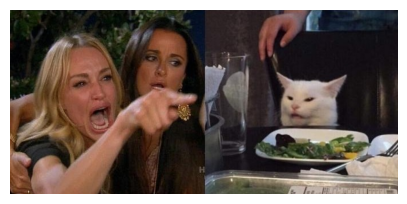

In [79]:

lesson_path = 'Part1/Lesson1/'
photo_to_check = 'photo5.jpg'
img = PILImage.create(lesson_path + photo_to_check)
img.to_thumb(192)
img.show()

cat_check,_,probability = learn.predict(img)
print(cat_check)
print(type(cat_check))
if cat_check == 'True': print('This is a cat') 
else: print('This is NOT a cat')


print(f"Probability it's a cat: {probability[1].item():.6f}")

# Afterthoughts
Note: An owl in photo3 got recognized as a cat with 0.990255 probability. 

Also, the model did not recognize the cat in photo4 where there's a woman and a cat. It got 0.343531 probability.

However, photo5 (which is a crop of photo4) with a cat in main focus, is clearly recognized as a cat.

The model was only trained to distinguish between cats and dogs because those were the two kinds of animals present in the dataset.